In [234]:
#Project II - Did Cristiano Ronaldo perform better at Real Madrid when the sun was in his star sign (Aquarius)?

In [235]:
#Dataset - All Cristiano Ronaldo club goals (Kaggle)
#Web Scraping - Astrological Zodiac signs wikipedia page

In [236]:
#1 CLEANING, EXTRACTION (WEB SCRAPING), TRANSFORMATION, MORE CLEANING

In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [238]:
#Cleaning the dataset to only Real Madrid matches

In [239]:
cr7 = pd.read_csv('data/cr7.csv', encoding='latin1')

In [240]:
condition_madrid = cr7['Club'] == 'Real Madrid'
cr7_rm = cr7[condition_madrid]

In [241]:
desired_columns = ['Season', 'Competition', 'Matchday', 'Date', 'Venue', 'Club', 'Opponent']
cr7_rm = cr7_rm[desired_columns]

In [242]:
cr7_rm = cr7_rm.reset_index(drop=True)

In [243]:
#Web Scraping astrological signs wikipedia page to get signs, and date ranges

In [244]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import requests

In [245]:
html = requests.get("https://en.wikipedia.org/wiki/Astrological_sign")

In [246]:
soup = BeautifulSoup(html.content, "html.parser")

In [247]:
#finding html tags and attributes

In [248]:
#Signs:

In [249]:
signs = soup.find_all("th", {"scope": "row", "class":""})

In [250]:
#using empty class because before it was giving me more unnecessary information with the same tag and attributes. This works :)

In [251]:
signs_simple = [i.getText().replace("\n", "") for i in signs]

In [252]:
#Date range:

In [253]:
dates = soup.find_all('span', {"class": "nowrap"})

In [254]:
pattern = re.compile(r'\d{1,2} [A-Za-z]+')

In [255]:
filtered_dates = [span for span in dates if pattern.match(span.get_text())]

In [256]:
dates_simple = [i.getText().replace("\n", "") for i in filtered_dates]

In [257]:
date_ranges = []
for i in range(0, len(dates_simple), 2):
    if i + 1 < len(dates_simple):
        pair = f"{dates_simple[i]} - {dates_simple[i + 1]}"
        date_ranges.append(pair)

In [258]:
star_signs = {key: value for key, value in zip(signs_simple, date_ranges)}

In [259]:
#Now time to add a column to the dataframe with the corresponding star sign of the date where the goal was scored
#First I will have to standardise the dates a bit

In [260]:
import datetime
import pandas as pd

In [261]:
cr7_rm['Date'] = pd.to_datetime(cr7_rm['Date']).dt.strftime('%d-%m')

/var/folders/q9/jkycd7cd6tqdf410bnlz4q2c0000gn/T/ipykernel_15909/3177540925.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cr7_rm['Date'] = pd.to_datetime(cr7_rm['Date']).dt.strftime('%d-%m')


In [262]:
#No need to include year in the date column - we know already from the season, and it is not relevant to astrological sign

In [263]:
#Now standardising dates in the star_signs dictionary

In [264]:
from dateutil import parser

In [265]:
date_ranges = {}
for sign, date_range in star_signs.items():
    start_date, end_date = map(str.strip, date_range.split(' - '))
    start_date = parser.parse(start_date).strftime('%d-%m')
    end_date = parser.parse(end_date).strftime('%d-%m')
    date_ranges[sign] = (start_date, end_date)

In [266]:
#Now I'll make a function to determine which sign the date of each goal belongs to

In [267]:
def determine_star_sign(date):
    year = 2022
    date = datetime.date(year, int(str(date).split('-')[1]), int(str(date).split('-')[0]))
    for sign, (start_date, end_date) in date_ranges.items():
        if (int(str(start_date).split('-')[1]) == 12) and (int(str(end_date).split('-')[1]) == 1):
            start_date = datetime.date(2022, int(str(start_date).split('-')[1]), int(str(start_date).split('-')[0]))
            end_date = datetime.date(2023, int(str(end_date).split('-')[1]), int(str(end_date).split('-')[0]))
        else:
            start_date = datetime.date(year, int(str(start_date).split('-')[1]), int(str(start_date).split('-')[0]))
            end_date = datetime.date(year, int(str(end_date).split('-')[1]), int(str(end_date).split('-')[0]))
        if start_date <= date <= end_date:
            return sign
    return 'Unknown'

In [268]:
cr7_rm['Star Sign'] = cr7_rm['Date'].apply(determine_star_sign)

In [269]:
cr7_rm['Star Sign'] = cr7_rm['Star Sign'].replace(['Unknown'], 'Capricorn')
cr7_rm['Season'] = cr7_rm['Season'].replace(['Dec-13'], '12/13')
#Work around - the function was returning unknowns for Capricorn - it didn't recognise the new year
#since I know all the unknowns are capricorns, I am doing this :) imperfect manual solution but it works.

In [270]:
#New column for distance of sign from Ronaldo's sign (Aquarius) eg. Pisces and Capricorn are 1 sign (1 month) away from Aquarius.

In [271]:
distance_from_aquarius = {
    'Aquarius': '0', 
    'Pisces': '1', 
    'Aries': '2', 
    'Taurus': '3', 
    'Gemini': '4', 
    'Cancer': '5', 
    'Leo': '6', 
    'Virgo': '5', 
    'Libra': '4', 
    'Scorpio': '3', 
    'Sagittarius': '2', 
    'Capricorn': '1'}

In [272]:
cr7_rm['Distance from Aquarius'] = cr7_rm['Star Sign'].apply(lambda x: distance_from_aquarius.get(x, 'Unknown'))

In [273]:
# ^ this is the final, clean dataset :)

In [274]:
#2. VISUALISATION

In [275]:
#Visualisation:

In [276]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")

In [277]:
#1. Compare total goals scored by Cristiano Ronaldo for Real Madrid in each star sign

In [278]:
goals_by_star_sign = cr7_rm['Star Sign'].value_counts().reset_index()
goals_by_star_sign.columns = ['Star Sign', 'Total Goals']
goals_by_star_sign = goals_by_star_sign.sort_values(by='Total Goals', ascending=False)

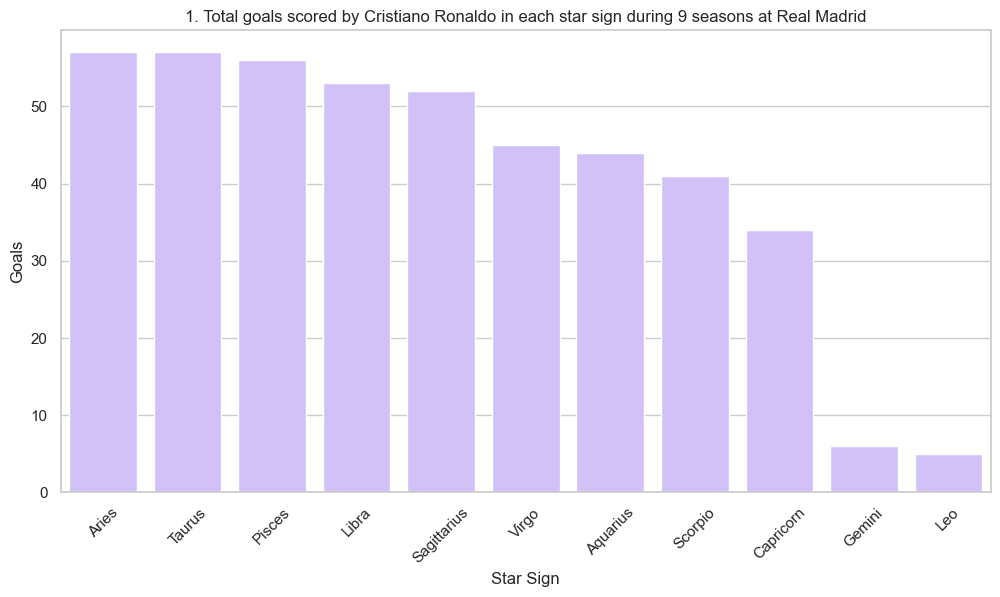

In [298]:
sns.countplot(data=cr7_rm, x='Star Sign', color='#CDB8FF', order=goals_by_star_sign['Star Sign'])
plt.xlabel("Star Sign")
plt.title("1. Total goals scored by Cristiano Ronaldo in each star sign during 9 seasons at Real Madrid")
plt.ylabel("Goals")
plt.xticks(rotation=45)
plt.savefig("images/figure1.png")
plt.show()

In [299]:
#2. Same thing, but show if there's a different in Home vs Away matches

In [300]:
import matplotlib.pyplot as plt

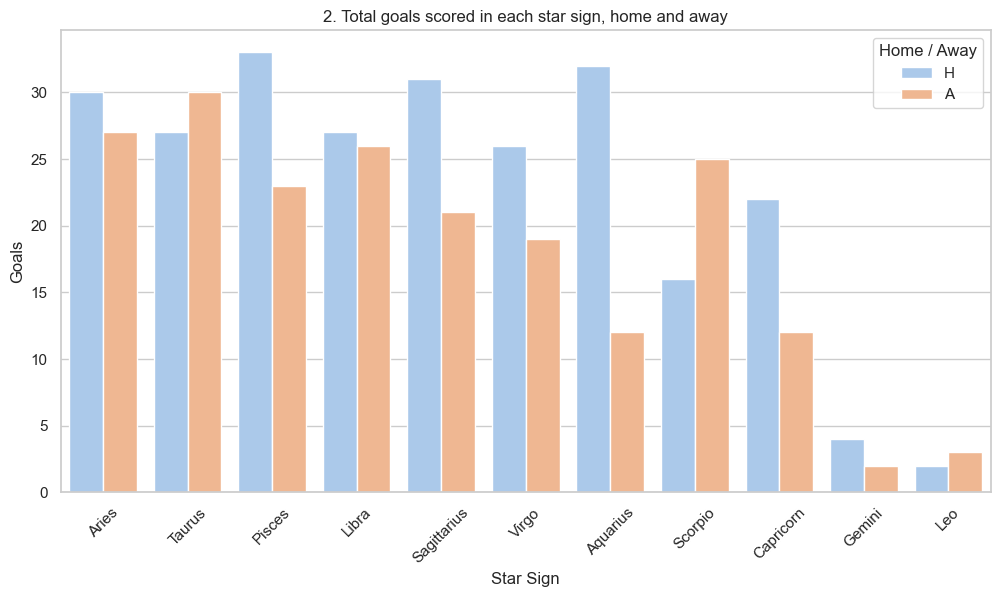

In [301]:
sns.countplot(data=cr7_rm, x='Star Sign', hue='Venue', palette='pastel', order=goals_by_star_sign['Star Sign'])
plt.xlabel("Star Sign")
plt.title("2. Total goals scored in each star sign, home and away")
plt.ylabel("Goals")
plt.xticks(rotation=45)
plt.legend(title='Home / Away', loc='upper right')
plt.savefig("images/figure2.png")
plt.show()

In [302]:
#3. Compare total goals scored in each star sign, only taking 'Important' matches into account.
        #Defining and filtering important matches as:
            #vs Barcelona or Atletico de Madrid
            #Champions League knock-out matches
            #Copa del Rey Semi-Finals or Final

In [303]:
condition_cl = (cr7_rm['Competition'] == 'UEFA Champions League') & (cr7_rm['Matchday'].isin(['last 16', 'Quarter-Finals', 'Semi-Finals', 'Final']))
condition_copa = (cr7_rm['Competition'] == 'Copa del Rey') & (cr7_rm['Matchday'].isin(['Semi-Finals', 'Final']))
condition_clasico_derbi = cr7_rm['Opponent'].isin(['Atletico de Madrid', 'FC Barcelona'])
condition_big_games = (condition_cl | condition_copa | condition_clasico_derbi)

In [304]:
cr7_rm_big_games = cr7_rm[condition_big_games]

In [305]:
goals_by_star_sign_2 = cr7_rm_big_games['Star Sign'].value_counts().reset_index()
goals_by_star_sign_2.columns = ['Star Sign', 'Total Goals']
goals_by_star_sign_2 = goals_by_star_sign_2.sort_values(by='Total Goals', ascending=False)

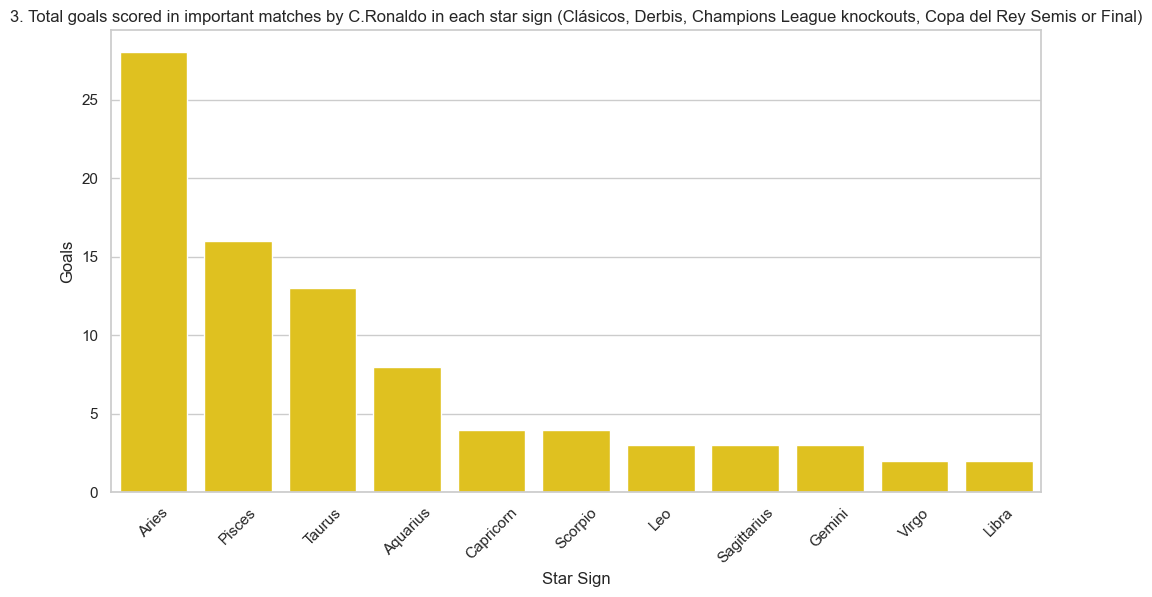

In [306]:
sns.countplot(data=cr7_rm_big_games, x='Star Sign', color='#FFD700', order=goals_by_star_sign_2['Star Sign'])
plt.xlabel("Star Sign")
plt.title("3. Total goals scored in important matches by C.Ronaldo in each star sign (Clásicos, Derbis, Champions League knockouts, Copa del Rey Semis or Final)")
plt.ylabel("Goals")
plt.xticks(rotation=45)
plt.savefig("images/figure3.png")
plt.show()

In [307]:
#4. Is there a relationship between how far the sun was from Aquarius, and Cristiano Ronaldo's performance? 
    #Did months closer to Aquarius produce better performances?
    #Can we say that the closer the sun got to Aquarius, the better Ronaldo performed?

In [308]:
#I have noticed that in order to weigh the counts fairly when looking at distance from Aquarius, I must divide the count of 1, 2, 3, 4, and 5 by 2, since for 0 and 6 there is only 1 sign and for the others 2
#This ensures that it takes the average over the 2 signs which are 1, 2, 3, 4 and 5 signs away from Aquarius
#I will do this by manually replacing values in each of the goals_by_distance tables

In [309]:
goals_by_distance = cr7_rm['Distance from Aquarius'].value_counts().reset_index()
goals_by_distance.columns = ['Distance from Aquarius', 'Total Goals']
goals_by_distance = goals_by_distance.sort_values(by='Distance from Aquarius', ascending=True)

In [310]:
goals_by_distance_df = pd.DataFrame(goals_by_distance)
goals_by_distance_df['Weighted_total_goals'] = ['44', '45', '55.5', '49', '29.5', '22.5', '5']
#Doing this manually after about 4 hours trying to find a function that would do it haha sorry!

In [311]:
goals_by_distance_big_games = cr7_rm_big_games['Distance from Aquarius'].value_counts().reset_index()
goals_by_distance_big_games.columns = ['Distance from Aquarius', 'Total Goals']
goals_by_distance_big_games = goals_by_distance_big_games.sort_values(by='Distance from Aquarius', ascending=True)
goals_by_distance_big_games_df = pd.DataFrame(goals_by_distance_big_games)
goals_by_distance_big_games_df['Weighted_total_goals'] = ['8', '10', '15.5', '8.5', '2.5', '1', '3']

In [312]:
#also going to filter a subset for home games only :)

In [313]:
condition_home = cr7_rm['Venue'] == 'H'
cr7_rm_home = cr7_rm[condition_home]

In [314]:
goals_by_distance_home = cr7_rm_home['Distance from Aquarius'].value_counts().reset_index()
goals_by_distance_home.columns = ['Distance from Aquarius', 'Total Goals']
goals_by_distance_home = goals_by_distance_home.sort_values(by='Distance from Aquarius', ascending=True)
goals_by_distance_home_df = pd.DataFrame(goals_by_distance_home)
goals_by_distance_home_df['Weighted_total_goals'] = ['32', '27.5', '30.5', '21.5', '15.5', '13', '2']

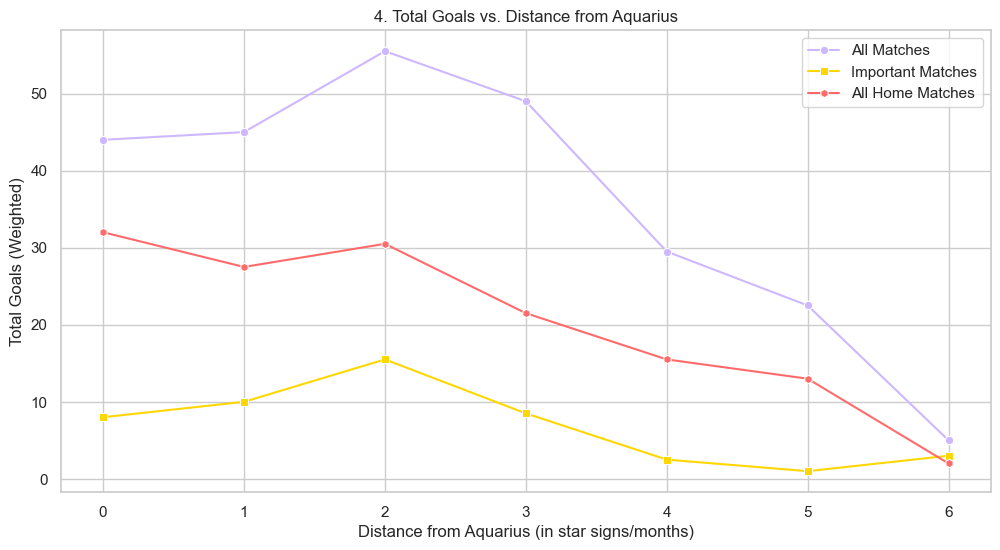

In [315]:
custom_labels = ['All Matches', 'Important Matches', 'All Home Matches']

Weighted_total_goals_as_float1 = goals_by_distance_df['Weighted_total_goals'].astype(float)
Weighted_total_goals_as_float2 = goals_by_distance_big_games_df['Weighted_total_goals'].astype(float)
Weighted_total_goals_as_float3 = goals_by_distance_home_df['Weighted_total_goals'].astype(float)

sns.lineplot(data=goals_by_distance_df, x='Distance from Aquarius', y=Weighted_total_goals_as_float1, label=custom_labels[0], color='#CDB8FF', marker='o')
sns.lineplot(data=goals_by_distance_big_games_df, x='Distance from Aquarius', y=Weighted_total_goals_as_float2, label=custom_labels[1], color='#FFD700', marker='s')
sns.lineplot(data = goals_by_distance_home_df, x='Distance from Aquarius', y=Weighted_total_goals_as_float3, label=custom_labels[2], color='#FF6B6B', marker='h')
plt.xlabel("Distance from Aquarius (in star signs/months)")
plt.ylabel("Total Goals (Weighted)")
plt.title("4. Total Goals vs. Distance from Aquarius")
plt.savefig("images/figure4.png")
plt.show()